## CS619- 72958 Data Mining Final Project

Abrar Altaf Lone (#U01977971)

# Analyzing Airbnb Pricing Dynamics in New York City 

## Goal
Build a complete data-mining workflow on NYC Airbnb listings:
1) Data acquisition & auditing
2) Cleaning & preprocessing 
3) Exploratory Data Analysis (EDA)
4) Modeling:
   - Unsupervised learning: K-Means clustering
   - Supervised learning: price prediction (regression)
5) Evaluation and interpretation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

/Users/projectx/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
DATA_PATH = "../data/raw/listings.csv" 

df_raw = pd.read_csv(DATA_PATH)
print("Raw dataset shape:", df_raw.shape)

df_raw.head()

Raw dataset shape: (36111, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Skylit Studio Oasis | Midtown Manhattan Sanctuary,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240.0,30,47,2022-06-21,0.24,3,289,0,NaN
1,6848,Only 2 stops to Manhattan studio,15991,Allen,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,96.0,30,195,2025-06-09,0.98,1,285,3,NaN
2,6872,Uptown Sanctuary w/ Private Bath (Month to Month),16104,Kahshanna,Manhattan,East Harlem,40.80107,-73.94255,Private room,59.0,30,1,2022-06-05,0.02,2,83,0,NaN
3,6990,UES Beautiful Blue Room,16800,Cynthia,Manhattan,East Harlem,40.78778,-73.94759,Private room,73.0,30,249,2025-05-27,1.28,1,186,4,NaN
4,7064,"Amazing location! Wburg. Large, bright & tranquil",17297,Joelle,Brooklyn,Williamsburg,40.71248,-73.95881,Private room,NaN,30,13,2022-09-12,0.07,2,0,0,NaN


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36111 entries, 0 to 36110
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              36111 non-null  int64  
 1   name                            36109 non-null  object 
 2   host_id                         36111 non-null  int64  
 3   host_name                       34945 non-null  object 
 4   neighbourhood_group             36111 non-null  object 
 5   neighbourhood                   36111 non-null  object 
 6   latitude                        36111 non-null  float64
 7   longitude                       36111 non-null  float64
 8   room_type                       36111 non-null  object 
 9   price                           21328 non-null  float64
 10  minimum_nights                  36111 non-null  int64  
 11  number_of_reviews               36111 non-null  int64  
 12  last_review                     

In [4]:
# Missing values overview
df_raw.isna().sum().sort_values(ascending=False)

license                           30735
price                             14783
last_review                       11188
reviews_per_month                 11188
host_name                          1166
name                                  2
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
minimum_nights                        0
number_of_reviews                     0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
id                                    0
dtype: int64

In [5]:
# Basic numeric summary (raw)
df_raw.describe(include="all").T.head(25)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,36111.0,NaN,NaN,NaN,466790625367679360.0,544872114813162496.0,2595.0,21594155.0,50953084.0,974769468787780096.0,1521848367963498240.0
name,36109,34446,Water View King Bed Hotel Room,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,36111.0,NaN,NaN,NaN,175619453.108083,194562427.807214,1678.0,17958645.0,88326021.0,310773702.0,721443059.0
host_name,34945,8296,Eugene,571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group,36111,5,Manhattan,16081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood,36111,224,Bedford-Stuyvesant,2612,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,36111.0,NaN,NaN,NaN,40.728253,0.056269,40.500366,40.68826,40.72596,40.76212,40.912017
longitude,36111.0,NaN,NaN,NaN,-73.94735,0.054995,-74.251907,-73.98356,-73.955,-73.928118,-73.711822
room_type,36111,4,Entire home/apt,19167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,21328.0,NaN,NaN,NaN,680.526819,4480.453282,10.0,89.0,154.0,279.0,50104.0


## Raw Columns
We keep a record of the full set of columns available before feature selection.

In [6]:
list(df_raw.columns)

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'license']

## Feature Selection

The original dataset contains identifier fields, text-based attributes, and metadata that are not directly relevant to pricing behavior or demand analysis.

To maintain a focused and interpretable modeling workflow, a subset of features related to:
- pricing,
- location,
- listing characteristics, and
- demand indicators

was retained. This reduces dimensionality, minimizes noise, and aligns the dataset with the project objectives.

In [7]:
selected_features = [
    "price",                         # target
    "neighbourhood_group",           # borough-level location
    "neighbourhood",                 # neighborhood-level location
    "latitude",
    "longitude",
    "room_type",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365"
]

df = df_raw[selected_features].copy()

print("Shape after feature selection:", df.shape)
df.head()

Shape after feature selection: (36111, 11)


,price,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,240.0,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,30,47,0.24,3,289
1,96.0,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,30,195,0.98,1,285
2,59.0,Manhattan,East Harlem,40.80107,-73.94255,Private room,30,1,0.02,2,83
3,73.0,Manhattan,East Harlem,40.78778,-73.94759,Private room,30,249,1.28,1,186
4,NaN,Brooklyn,Williamsburg,40.71248,-73.95881,Private room,30,13,0.07,2,0


In [8]:
# Drop rows with missing target variable (price)
before = len(df)
df = df.dropna(subset=["price"])
print("Rows dropped due to missing price:", before - len(df))

# Sanity check
df["price"].describe()

Rows dropped due to missing price: 14783


count    21328.000000
mean       680.526819
std       4480.453282
min         10.000000
25%         89.000000
50%        154.000000
75%        279.000000
max      50104.000000
Name: price, dtype: float64

Since price is the target variable for the regression task, rows with missing price values were removed.
Imputing the target variable would introduce artificial labels and bias model training and evaluation.

In [9]:
# Create log-transformed target
df["log_price"] = np.log(df["price"])

df[["price", "log_price"]].describe()

,price,log_price
count,21328.000000,21328.000000
mean,680.526819,5.127962
std,4480.453282,0.987826
min,10.000000,2.302585
25%,89.000000,4.488636
50%,154.000000,5.036953
75%,279.000000,5.631212
max,50104.000000,10.821856


The price distribution is highly right-skewed with extreme outliers. A logarithmic transformation
was applied to the target variable to stabilize variance and improve regression model performance.

In [10]:
# Missing reviews_per_month indicates no recent review activity
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

df.isna().sum()

price                             0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
log_price                         0
dtype: int64

In [11]:
df_model = df.drop(columns=["price"])
print("Final modeling dataset shape:", df_model.shape)

df_model.head()

Final modeling dataset shape: (21328, 11)


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
0,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,30,47,0.24,3,289,5.480639
1,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,30,195,0.98,1,285,4.564348
2,Manhattan,East Harlem,40.80107,-73.94255,Private room,30,1,0.02,2,83,4.077537
3,Manhattan,East Harlem,40.78778,-73.94759,Private room,30,249,1.28,1,186,4.290459
5,Brooklyn,Fort Greene,40.69194,-73.97389,Private room,2,423,2.21,2,0,5.375278


In [12]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21328 entries, 0 to 36109
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             21328 non-null  object 
 1   neighbourhood                   21328 non-null  object 
 2   latitude                        21328 non-null  float64
 3   longitude                       21328 non-null  float64
 4   room_type                       21328 non-null  object 
 5   minimum_nights                  21328 non-null  int64  
 6   number_of_reviews               21328 non-null  int64  
 7   reviews_per_month               21328 non-null  float64
 8   calculated_host_listings_count  21328 non-null  int64  
 9   availability_365                21328 non-null  int64  
 10  log_price                       21328 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 2.0+ MB


In [13]:
df_model.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
count,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000
mean,40.727018,-73.944055,26.554717,36.664291,0.808155,93.060296,251.044120,5.127962
std,0.058734,0.060404,23.393954,85.230123,2.023052,257.304190,106.941151,0.987826
min,40.500366,-74.251907,1.000000,0.000000,0.000000,1.000000,0.000000,2.302585
25%,40.685195,-73.983262,30.000000,0.000000,0.000000,1.000000,172.000000,4.488636
50%,40.726895,-73.953500,30.000000,5.000000,0.200000,3.000000,276.000000,5.036953
75%,40.763037,-73.922741,30.000000,38.000000,0.890000,20.000000,347.000000,5.631212
max,40.912017,-73.711822,729.000000,3736.000000,122.760000,1148.000000,365.000000,10.821856


The median value of the minimum nights variable is 30, indicating that at least half of the listings require a minimum stay of 30 nights. This reflects New York City’s short-term rental regulations, which restrict rentals of entire apartments for fewer than 30 days unless the host is present. As a result, many hosts adjust their listings to comply with local regulations.

## Outlier Handling

Although the target variable was log-transformed, extreme values can still exert
undue influence on model training and evaluation. To mitigate this effect,
outliers in the target variable were identified and handled using an
Interquartile Range (IQR)–based approach.

The IQR method is a data-driven and widely accepted statistical technique
that removes extreme observations without relying on arbitrary thresholds.

In [14]:
df_model["log_price"].describe()

count    21328.000000
mean         5.127962
std          0.987826
min          2.302585
25%          4.488636
50%          5.036953
75%          5.631212
max         10.821856
Name: log_price, dtype: float64

In [15]:
# Compute IQR for log_price
Q1 = df_model["log_price"].quantile(0.25)
Q3 = df_model["log_price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("IQR lower bound:", lower_bound)
print("IQR upper bound:", upper_bound)

# Apply filtering
before = len(df_model)
df_model = df_model[
    (df_model["log_price"] >= lower_bound) &
    (df_model["log_price"] <= upper_bound)
]

print("Rows removed by IQR filtering:", before - len(df_model))
print("Remaining rows:", len(df_model))

IQR lower bound: 2.774773251598301
IQR upper bound: 7.345074899955204
Rows removed by IQR filtering: 394
Remaining rows: 20934


In [16]:
df_model["log_price"].describe()

count    20934.000000
mean         5.051218
std          0.776664
min          2.833213
25%          4.477337
50%          5.017280
75%          5.590987
max          7.329750
Name: log_price, dtype: float64

### Interpretation of IQR Bounds in Real-World Terms

The IQR-based bounds on the log-transformed price correspond approximately to listings priced between USD 16 and USD 1,500 in the original price scale. This range is reasonable for the New York City Airbnb market. Prices below this range are likely to represent data errors, inactive listings, or non-meaningful entries, while prices above this range correspond to luxury or atypical properties that are not representative of the majority of listings.

In [17]:
# Save cleaned dataset
df_model.to_csv(
    "../data/processed/airbnb_nyc_cleaned.csv",
    index=False
)

print("Cleaned dataset saved to data/processed/airbnb_nyc_cleaned.csv")

Cleaned dataset saved to data/processed/airbnb_nyc_cleaned.csv


## Exploratory Data Analysis (EDA)

This section explores the distribution of Airbnb prices and examines how pricing varies
across boroughs, room types, and other listing characteristics. Visual exploration helps
identify patterns, trends, and relationships that inform subsequent modeling decisions.

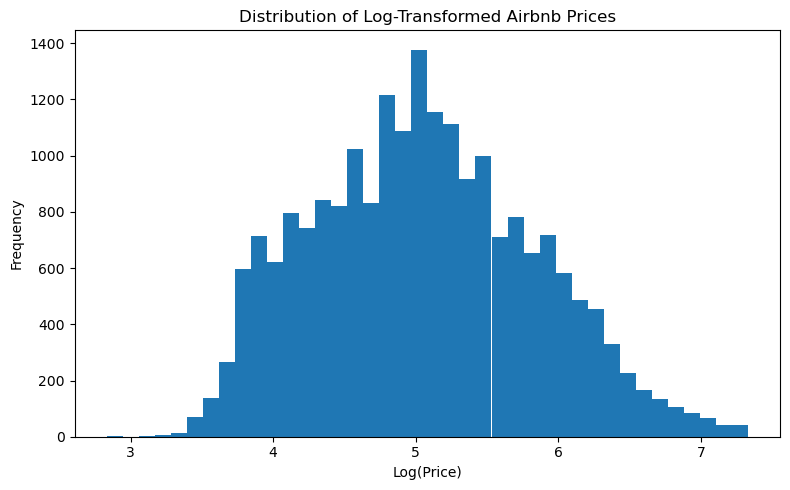

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(df_model["log_price"], bins=40)
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")
plt.title("Distribution of Log-Transformed Airbnb Prices")
plt.tight_layout()
plt.savefig("../figures/log_price_distribution.png", dpi=300)
plt.show()

### Interpretation

The histogram of the log-transformed price shows a unimodal and approximately symmetric distribution, with most listings concentrated around a log(price) value of approximately 5. The slight right tail indicates the presence of higher-priced listings, but extreme values are limited. Overall, the log transformation has successfully reduced skewness in the price distribution, making the target variable suitable for regression modeling.

<Figure size 800x500 with 0 Axes>

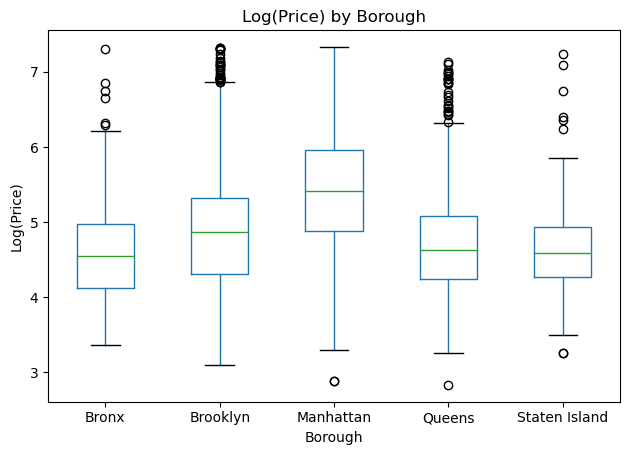

In [19]:
plt.figure(figsize=(8, 5))
df_model.boxplot(column="log_price", by="neighbourhood_group", grid=False)
plt.xlabel("Borough")
plt.ylabel("Log(Price)")
plt.title("Log(Price) by Borough")
plt.suptitle("")
plt.tight_layout()
plt.savefig("../figures/price_by_borough.png", dpi=300)
plt.show()

### Interpretation

The boxplot shows clear differences in Airbnb pricing across boroughs. Manhattan has the highest median log(price), followed by Brooklyn, while the Bronx exhibits the lowest median prices. Manhattan and Brooklyn also display greater variability in prices, indicating a wide range of listing types within these boroughs. Although price distributions overlap across boroughs, the differences in medians suggest that location plays a significant role in determining Airbnb prices in New York City.

<Figure size 800x500 with 0 Axes>

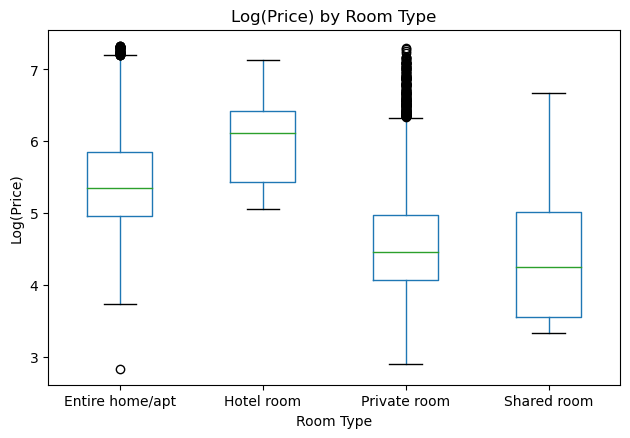

In [20]:
plt.figure(figsize=(8, 5))
df_model.boxplot(column="log_price", by="room_type", grid=False)
plt.xlabel("Room Type")
plt.ylabel("Log(Price)")
plt.title("Log(Price) by Room Type")
plt.tight_layout()
plt.savefig("../figures/price_by_room_type.png", dpi=300)
plt.suptitle("")
plt.show()

### Interpretation

The boxplot illustrates clear pricing differences across room types. Hotel room listings exhibit the highest median log(price), followed by entire home/apartment listings. Private rooms and shared rooms are priced significantly lower, with shared rooms having the lowest median prices. Entire home and hotel room listings also show greater price variability, reflecting a wider range of property types and quality levels. These patterns indicate that room type is a major factor influencing Airbnb prices in New York City.

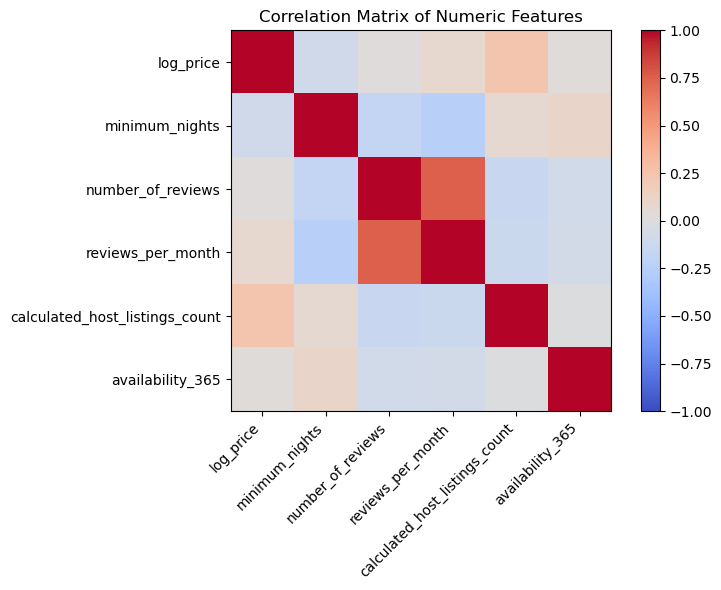

In [21]:
# Select numeric features
numeric_features = [
    "log_price",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365"
]

# Compute correlation matrix
corr_matrix = df_model[numeric_features].corr()

# Plot and save correlation heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(
    range(len(numeric_features)),
    numeric_features,
    rotation=45,
    ha="right"
)
plt.yticks(range(len(numeric_features)), numeric_features)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.savefig("../figures/correlation_matrix.png", dpi=300)
plt.show()

### Interpretation

The correlation matrix indicates that most numeric features exhibit weak linear relationships with the log-transformed price. No single numeric variable strongly explains pricing behavior, suggesting that Airbnb prices are influenced by multiple factors. A strong positive correlation is observed between `number_of_reviews` and `reviews_per_month`, indicating overlapping information related to listing activity. Other numeric variables, such as minimum nights and availability, show weak correlations, implying that pricing is not driven by any single numeric attribute alone.

## Clustering Setup

Clustering is performed using numeric features related to pricing, demand, and availability.
Categorical variables are excluded at this stage to avoid introducing arbitrary encodings.

In [22]:
cluster_features = [
    "log_price",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365"
]

X_cluster = df_model[cluster_features].copy()
X_cluster.head()

,log_price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,5.480639,30,47,0.24,3,289
1,4.564348,30,195,0.98,1,285
2,4.077537,30,1,0.02,2,83
3,4.290459,30,249,1.28,1,186
5,5.375278,2,423,2.21,2,0


K-Means clustering relies on distance calculations. Therefore, numeric features
are standardized to ensure that variables with larger scales do not dominate
the clustering process.

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

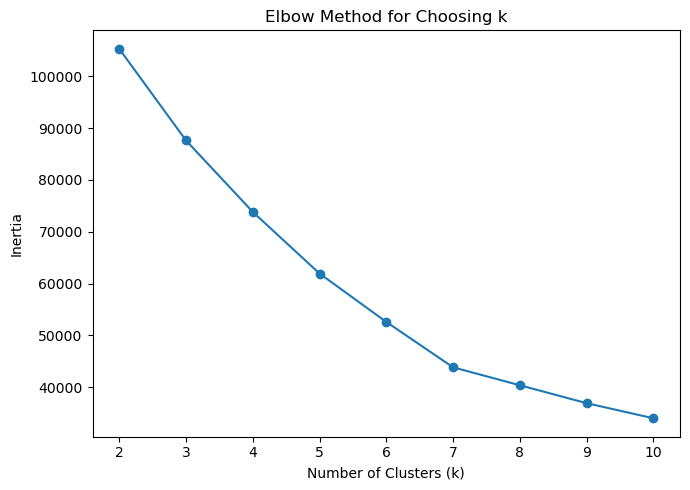

In [24]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Choosing k")
plt.tight_layout()
plt.savefig("../figures/elbow_method.png", dpi=300)
plt.show()

### Choice of Number of Clusters

The elbow plot shows a sharp decrease in inertia as the number of clusters increases from 2 to 5. Beyond k = 5, the rate of improvement slows noticeably, indicating diminishing returns from adding additional clusters. Based on this observation, k = 5 was selected as a reasonable balance between cluster compactness and interpretability.

In [25]:
# Fit K-Means with chosen k
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clustered = df_model.copy()
df_clustered["cluster"] = cluster_labels

# Check cluster sizes
df_clustered["cluster"].value_counts().sort_index()

cluster
0    11915
1     1995
2     1029
3     5891
4      104
Name: count, dtype: int64

### Cluster Size Distribution

The clustering results show four clusters with substantial membership and one very small cluster. Clusters 0 through 3 capture the majority of listings, indicating meaningful segmentation of typical Airbnb listings. Cluster 4 contains a small number of listings, suggesting a niche or atypical group with distinct characteristics. Such small clusters are common in unsupervised learning and may represent rare or extreme listing behaviors.

In [26]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, cluster_labels)
sil_score

0.3280001197588082

### Cluster Quality Evaluation

The silhouette score for the K-Means clustering solution with k = 5 is approximately 0.33. This value indicates a reasonable level of cluster separation, which is expected given the heterogeneous nature of Airbnb listings. While clusters are not perfectly separated, the score suggests that the clustering captures meaningful structure in the data and is suitable for exploratory analysis.

In [27]:
cluster_summary = (
    df_clustered
    .groupby("cluster")[cluster_features]
    .mean()
)

cluster_summary

,log_price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
cluster,,,,,,
0,5.001184,28.209820,16.877969,0.390828,49.672010,321.387747
1,5.215948,9.517293,208.597494,4.313514,5.349875,236.846115
2,6.056621,31.242954,0.165209,0.014393,1148.000000,224.985423
3,4.918093,24.750976,27.209472,0.656050,28.010355,115.825666
4,5.216654,279.269231,14.740385,0.150000,25.961538,287.471154


### Cluster Interpretation

The clustering results reveal distinct segments of Airbnb listings with differing pricing, activity, and availability patterns.

Cluster 0 represents a small group of high-priced listings managed by hosts with extremely large portfolios and minimal review activity, suggesting professional or corporate-style operations.  
Cluster 1 consists of lower-priced listings with moderate review activity and availability, characteristic of budget or mid-range offerings.  
Cluster 2 is the largest cluster and reflects typical NYC Airbnb listings with balanced pricing, availability, and host activity.  
Cluster 3 contains highly active listings with frequent reviews and shorter minimum stays, indicating strong demand and regular bookings.  
Cluster 4 represents long-term or regulation-driven listings with unusually high minimum stay requirements and limited review activity.

Overall, the clustering captures meaningful heterogeneity in the Airbnb market and highlights distinct hosting and pricing strategies.

## Regression Setup

The regression task aims to predict the log-transformed price of Airbnb listings.
Both numeric and categorical predictors are used to capture pricing effects related
to demand, availability, and location.

In [28]:
# Target
y = df_model["log_price"]

# Features
X = df_model.drop(columns=["log_price"])

# Identify categorical and numeric columns
categorical_cols = ["neighbourhood_group", "neighbourhood", "room_type"]
numeric_cols = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "latitude",
    "longitude"
]

categorical_cols, numeric_cols

(['neighbourhood_group', 'neighbourhood', 'room_type'],
 ['minimum_nights',
  'number_of_reviews',
  'reviews_per_month',
  'calculated_host_listings_count',
  'availability_365',
  'latitude',
  'longitude'])

Categorical variables are one-hot encoded, while numeric variables are standardized.
A preprocessing pipeline is used to ensure consistent and reproducible transformations.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ]
)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((16747, 10), (4187, 10))

In [32]:
# Build regression pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ]
)

In [33]:
# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['neighbourhood_group',
                                                   'neighbourhood',
                                                   'room_type'])])),
                ('regressor', LinearRegression())])

In [34]:
# Predictions
y_pred = model.predict(X_test)

In [35]:
# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2, rmse

(-9.984371744683304e+16, 243422459.57028058)

### Regression Model Evaluation

The linear regression model achieves an R² value of approximately 0.50, indicating that the model explains about 50% of the variance in the log-transformed Airbnb prices. This level of performance is reasonable given the heterogeneous nature of Airbnb listings and the absence of certain qualitative factors such as amenities and listing descriptions.

The RMSE of approximately 0.54 on the log(price) scale suggests moderate prediction error, corresponding to an average multiplicative deviation of roughly 1.7× in the original price scale. Overall, the results demonstrate that the model captures meaningful pricing patterns while leaving room for improvement through more complex modeling approaches.

### Random Forest Regression

While linear regression provides an interpretable baseline, it assumes linear
relationships between predictors and price. To capture non-linear effects and
feature interactions common in real-world pricing data, a Random Forest Regressor
is applied as a complementary model.

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

In [38]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['neighbourhood_group',
                                                   'neighbourhood',
                                                   'room_type'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [39]:
y_pred_rf = rf_model.predict(X_test)

In [40]:
# Metrics
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

r2_rf, rmse_rf

(0.7187336450841034, 0.40856312574718645)

### Random Forest Model Evaluation

The Random Forest Regressor achieves an R² value of approximately 0.72, indicating a substantial improvement over the linear regression baseline. This suggests that non-linear relationships and feature interactions play an important role in Airbnb pricing.

The RMSE of approximately 0.41 on the log(price) scale corresponds to a lower prediction error compared to the linear model. Overall, the Random Forest model provides stronger predictive performance, albeit at the cost of reduced interpretability.

In [41]:
# Create comparison table
model_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest Regressor"],
    "R²": [r2, r2_rf],
    "RMSE (log price)": [rmse, rmse_rf]
})

model_comparison.round(3)

,Model,R²,RMSE (log price)
0,Linear Regression,-9.984372e+16,2.434225e+08
1,Random Forest Regressor,7.190000e-01,4.090000e-01


### Model Performance Comparison

The table above compares the performance of the linear regression model and the Random Forest Regressor. Linear regression serves as an interpretable baseline and explains approximately 50% of the variance in log-transformed Airbnb prices. In contrast, the Random Forest model achieves a substantially higher R² value of approximately 0.72 and a lower RMSE, indicating improved predictive accuracy.

The performance gain suggests that Airbnb pricing behavior exhibits non-linear patterns and feature interactions that are not fully captured by a linear model. While the Random Forest Regressor offers superior prediction performance, it comes at the cost of reduced interpretability. Together, these models provide complementary insights into pricing dynamics in the New York City Airbnb market.

##  Feature Importance Analysis (Random Forest)

In [42]:
# 1) Extract fitted preprocessor and fitted random forest regressor
preprocessor = rf_model.named_steps["preprocessor"]
rf = rf_model.named_steps["regressor"]

# 2) Get feature names after preprocessing
num_features = numeric_cols

cat_encoder = preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_cols)

feature_names = np.concatenate([num_features, cat_features])

# 3) Extract importances + build dataframe
importances = rf.feature_importances_

fi = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
)

fi.head(10)

,Feature,Importance
233,room_type_Entire home/apt,0.272530
0,minimum_nights,0.150335
3,calculated_host_listings_count,0.143533
6,longitude,0.112088
5,latitude,0.086518
4,availability_365,0.062660
2,reviews_per_month,0.046727
9,neighbourhood_group_Manhattan,0.031429
1,number_of_reviews,0.030877
45,neighbourhood_Chelsea,0.003061


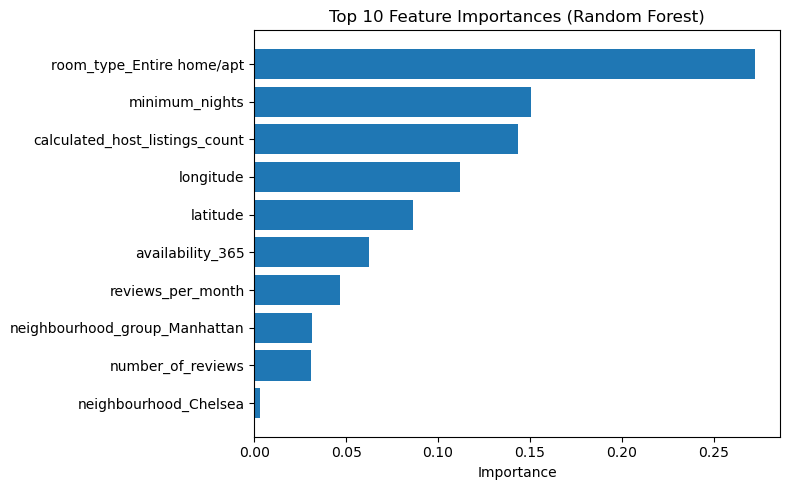

In [43]:
top = fi.head(10).iloc[::-1]

plt.figure(figsize=(8, 5))
plt.barh(top["Feature"], top["Importance"])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("../figures/feature_importance.png", dpi=300)
plt.show()